In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
# from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
dict(zip(os.listdir()[4:-1],list(range(12))))

{'RUL_FD001.txt': 0,
 'RUL_FD002.txt': 1,
 'RUL_FD003.txt': 2,
 'RUL_FD004.txt': 3,
 'test_FD001.txt': 4,
 'test_FD002.txt': 5,
 'test_FD003.txt': 6,
 'test_FD004.txt': 7,
 'train_FD001.txt': 8,
 'train_FD002.txt': 9,
 'train_FD003.txt': 10,
 'train_FD004.txt': 11}

In [3]:
doc = os.listdir()[4:-1][8]
print(doc)

train_FD001.txt


In [4]:
files = sorted([i for i in os.listdir() if i.find('001')!=-1])
files

['RUL_FD001.txt', 'test_FD001.txt', 'train_FD001.txt']

### Importação do treino

In [5]:
# CRIAÇÃO DOS NOMES DAS COLUNAS
columns = ['engine','cicle']+[f'setting_{i+1}' for i in range(3)]+[f'sensor_{i+1}' for i in range(21)]
# IMPORTAÇÃO DO DATA FRAME
df_train = pd.read_csv(files[2],header=None,sep=' ')
# EXCLUI COLUNAS VAZIAS
df_train.drop(columns=[26,27],inplace=True)
# RENOMEIA AS COLUNAS
df_train.columns = columns
# CRIA UMA COLUNA DE CICLO MAXIMO PARA CADA MOTOR
df_train = df_train.merge(df_train.groupby('engine').max()['cicle'].reset_index().rename(columns = {'cicle':'max_cicle'}),on='engine',how='left')
# CRIA UMA COLUNA DE ROC PARA CADA LINHA
df_train['ROC'] = df_train['max_cicle'] - df_train['cicle']
# PEGA COLUNAS QUE SÃO PRATICAMENTE CONSTANTES PARA DROPAR
columns_to_drop = list(df_train.describe().columns[df_train.describe().loc['std'] < 10e-10])+['max_cicle']
# DROPA AS COLUNAS QUE SÃO CONSTANTES
df_train.drop(columns=columns_to_drop,inplace=True)
# COLUNAS COM BAIXA CORRELAÇÃO COM ROC
df_train.drop(columns=['sensor_9','setting_1','setting_2','engine','sensor_6','sensor_14','cicle'],inplace=True)

train_X = df_train.drop(columns='ROC')

train_Y = df_train['ROC']

### Importação do teste

In [6]:
# IMPORTAÇÃO DO DATA FRAME
test_X = pd.read_csv(files[1],header=None,sep=' ')
# EXCLUI COLUNAS VAZIAS
test_X.drop(columns=[26,27],inplace=True)
# RENOMEIA AS COLUNAS
test_X.columns = columns

test_X = test_X.groupby('engine').last().reset_index()

test_X = test_X[[i for i in df_train.columns if i in test_X.columns]]

test_Y = pd.read_csv(files[0],header=None,sep=' ')[0]

### Dropar colunas com alta e baixa correlação

<AxesSubplot:>

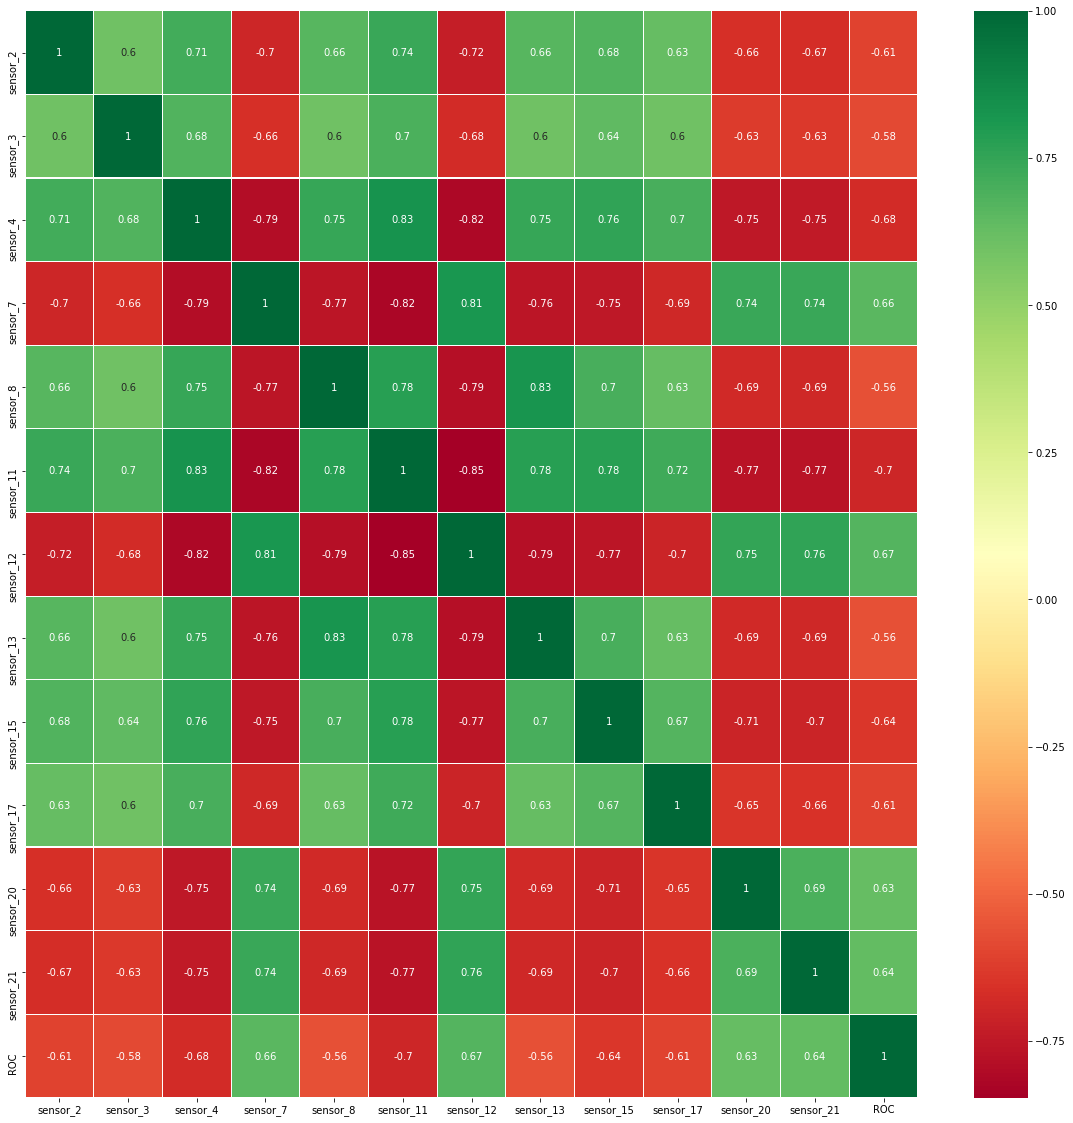

In [119]:
fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

### Avaliar cada coluna

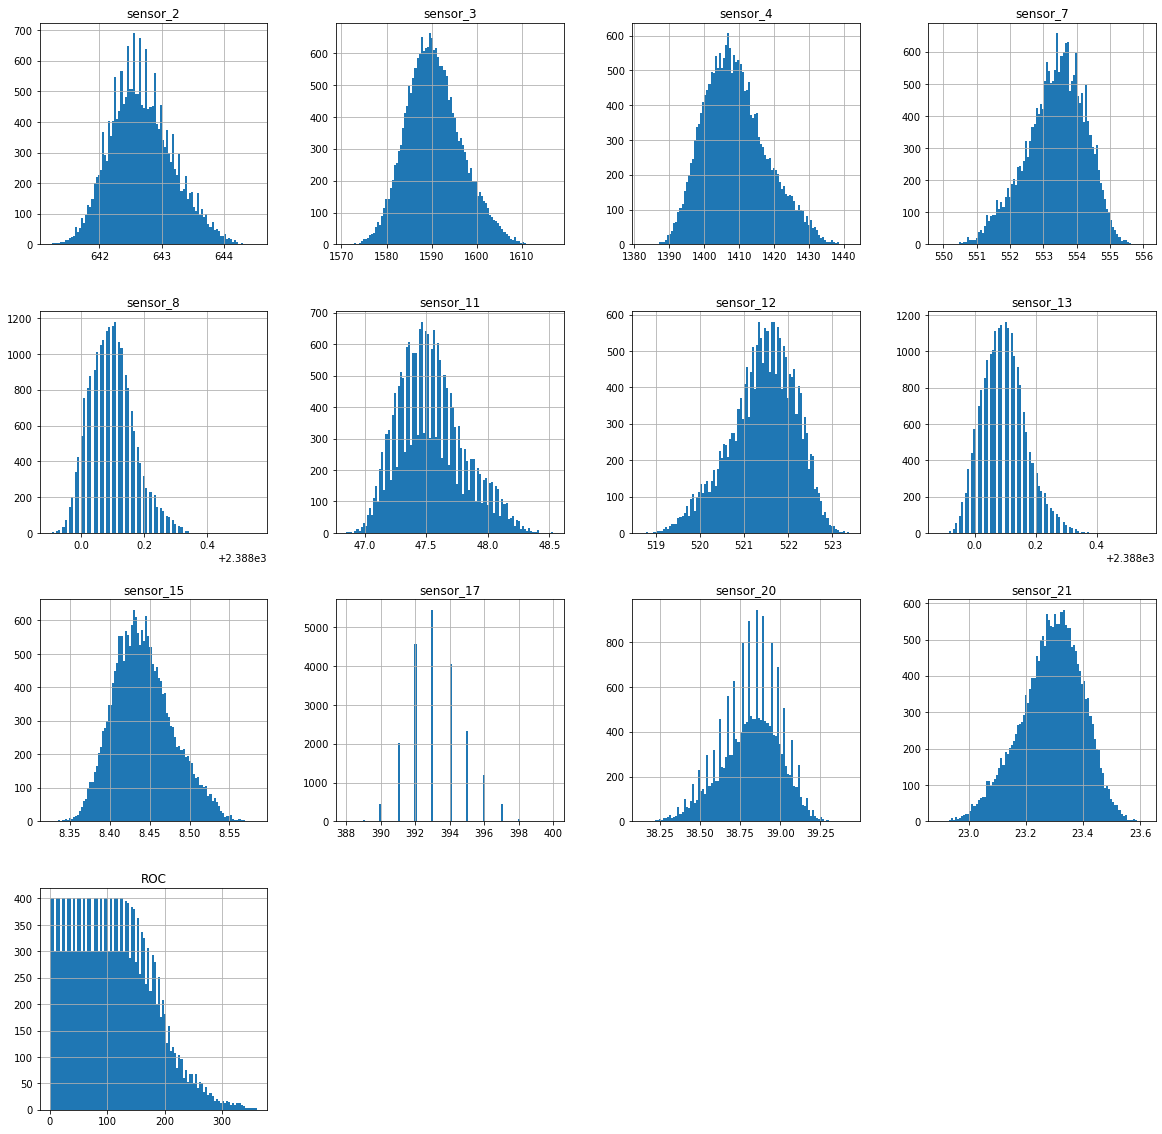

In [40]:
df_train.hist(bins=100,figsize=(20,20));

## PCA

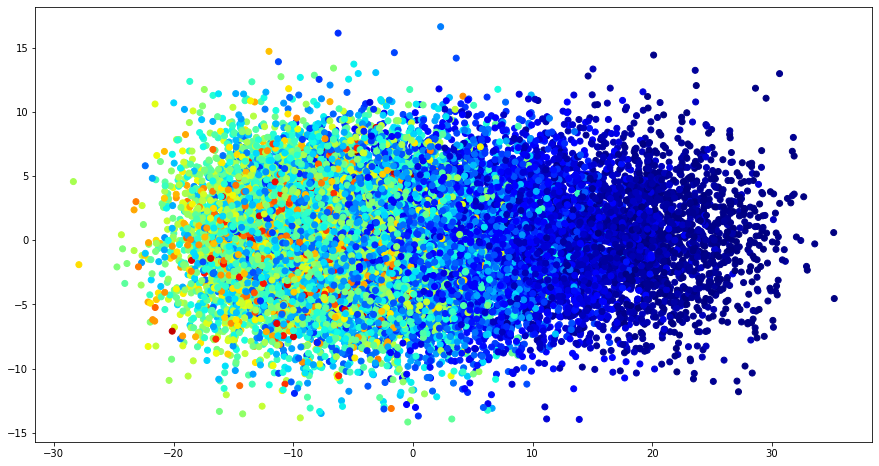

In [163]:
pca = PCA(n_components=2)
pca.fit(np.array(df_train.drop(columns='ROC')))
X = pca.transform(np.array(df_train.drop(columns='ROC')))
norm = plt.Normalize()
colors = plt.cm.jet(norm(df_train['ROC']))
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(X.T[0],X.T[1],color=colors)

Correlação com o primeiro componente é relativamente alta

In [164]:
pd.concat([pd.DataFrame(X),df_train['ROC']],axis=1).corr()

,0,1,ROC
0,1.000000e+00,1.556151e-16,-0.702246
1,1.556151e-16,1.000000e+00,-0.013746
ROC,-7.022457e-01,-1.374637e-02,1.000000


## Regression

In [7]:
from scipy.optimize import minimize,Bounds

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.svm import SVR,NuSVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [9]:
def get_score(test_Y,prediction):
    print(f'MSE: {mean_squared_error(np.array(test_Y), prediction)}')
    print(f'R2 score: {r2_score(np.array(test_Y), prediction)}')
    print(f'MAE: {mean_absolute_error(np.array(test_Y), prediction)}')
    return mean_squared_error(np.array(test_Y), prediction), r2_score(np.array(test_Y), prediction), mean_absolute_error(np.array(test_Y), prediction)

In [10]:
std_scale = StandardScaler().fit(train_X)
train_X_std = std_scale.transform(train_X)
test_X_std  = std_scale.transform(test_X)

In [163]:
minimize(optmize_params,900)['x']

array([900.])

In [234]:
def optmize_params(train_X_std=train_X_std,train_Y=train_Y,test_X_std=test_X_std,test_Y=test_Y):
    regr = regr = MLPRegressor(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    warm_start=True,
                                    verbose=False,
                                    solver='adam',
                                    learning_rate_init=0.001,
                                    max_iter=400).fit(train_X_std, train_Y)
    prediction = regr.predict(test_X_std)
    return mean_squared_error(np.array(test_Y), prediction)

In [21]:
prediction = pd.Series(prediction)

MSE: 529.4101191670576
R2 score: 0.6934278539809504
MAE: 18.289385597085925


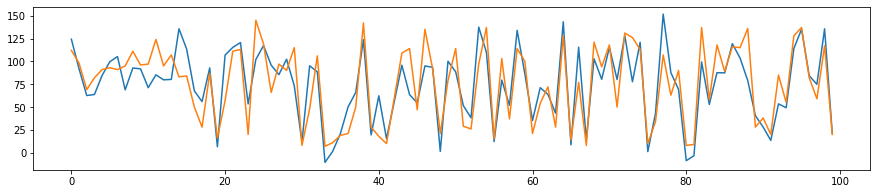

In [18]:
regr = LinearSVR(C=0.014)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 1263.265832098065
R2 score: 0.2684648382842194
MAE: 27.950571592441737


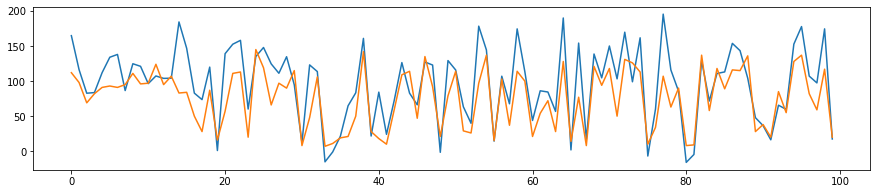

In [17]:
regr = MLPRegressor(hidden_layer_sizes=(100,50,50),
                                    activation='identity',
                                    warm_start=True,
                                    verbose=False,
                                    solver='adam',
                                    learning_rate_init=0.001,
                                    max_iter=200)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 2737.29
R2 score: -0.5851167916790014
MAE: 37.65


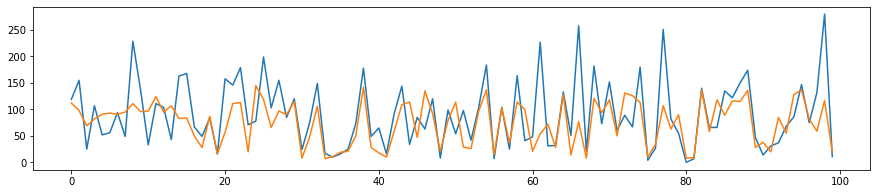

In [186]:
regr = DecisionTreeRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 1047.5264959578353
R2 score: 0.3933957167594845
MAE: 25.255041089255585


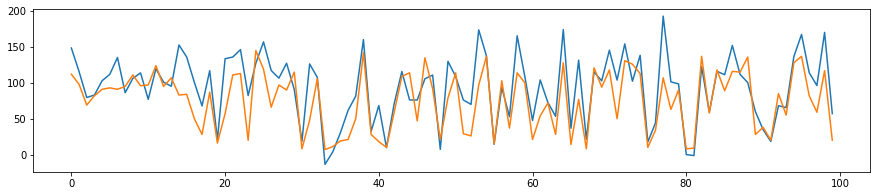

In [183]:
regr = PLSRegression(n_components=1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction.T[0]))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 1023.3632871800555
R2 score: 0.4073882085942936
MAE: 24.720715789473683


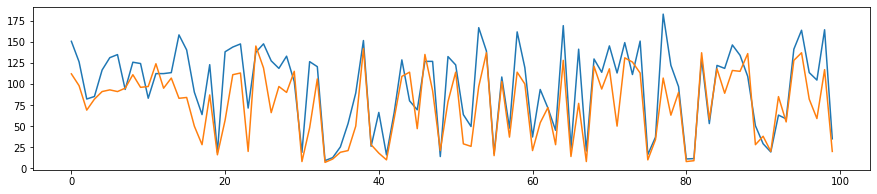

In [156]:
regr = KNeighborsRegressor(n_neighbors=950,leaf_size=30)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 992.6718884946755
R2 score: 0.4251610610930462
MAE: 25.19060736102933


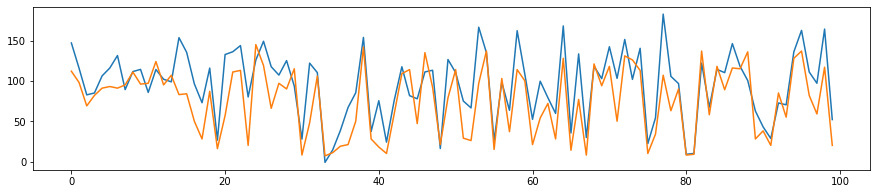

In [130]:
regr = linear_model.SGDRegressor(alpha=1,epsilon=5,verbose=0)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 529.2327267005721
R2 score: 0.6935305788575048
MAE: 18.289331172026934


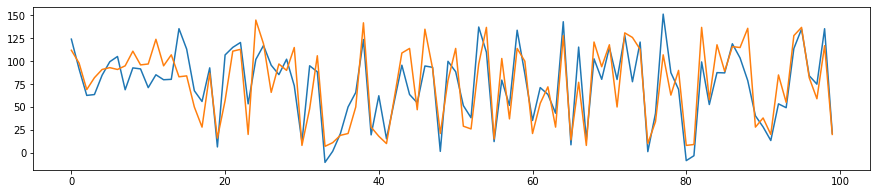

In [79]:
regr = LinearSVR(C=0.014)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 586.6481849891329
R2 score: 0.6602822905741506
MAE: 19.227636003607614


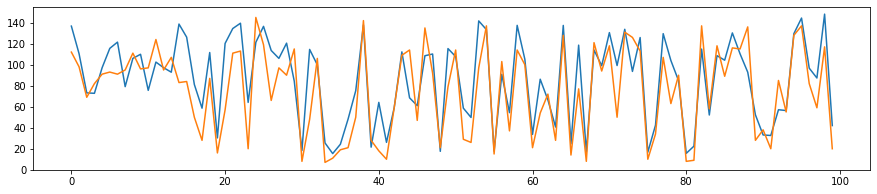

In [33]:
regr = NuSVR(nu=0.95,C=0.06)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 583.2774350029509
R2 score: 0.6622342329710644
MAE: 19.155574315437875


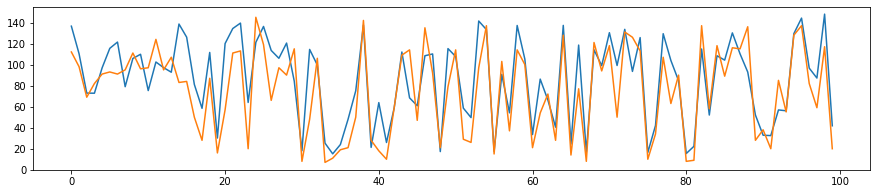

In [17]:
regr = SVR(C=0.06, epsilon=0.1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 1121.5257383996247
R2 score: 0.35054404895446356
MAE: 25.99650146484375


(1121.5257383996247, 0.35054404895446356, 25.99650146484375)

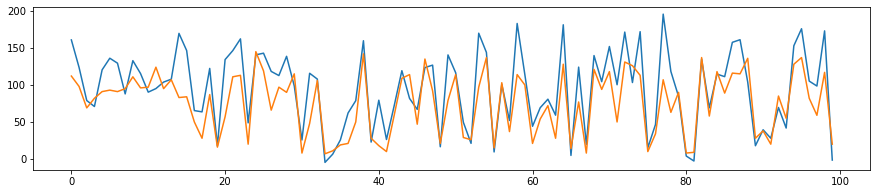

In [281]:
poly = PolynomialFeatures(degree=3)
train = poly.fit_transform(train_X_std)
test = poly.fit_transform(test_X_std)

regr = linear_model.LinearRegression()
regr.fit(train, train_Y)
prediction = regr.predict(test)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 1054.917961378336
R2 score: 0.38911544833591594
MAE: 25.488851131351442


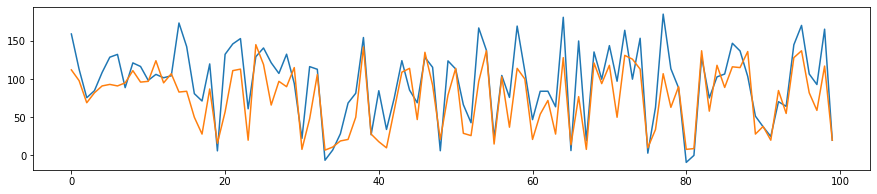

In [271]:
regr = linear_model.TheilSenRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 2739.8437243648355
R2 score: -0.5865956088200499
MAE: 41.45998018117939


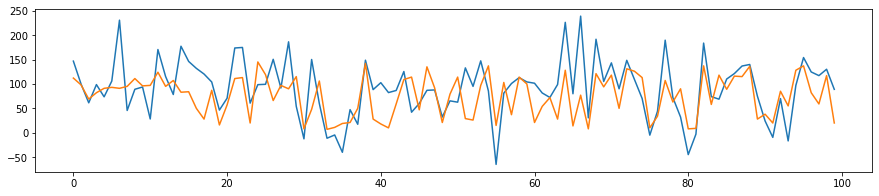

In [272]:
regr = linear_model.RANSACRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 804.1623449973735
R2 score: 0.5343236426205119
MAE: 22.06108545154893


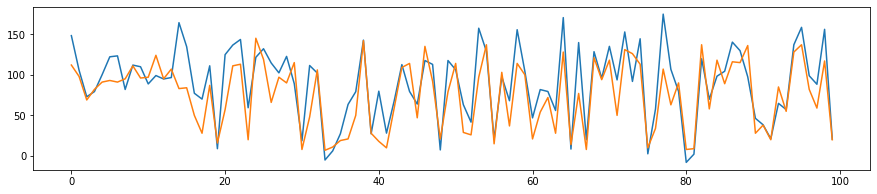

In [273]:
regr = linear_model.HuberRegressor(epsilon=1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 1108.9673286221391
R2 score: 0.3578164045379342
MAE: 26.118986140642573


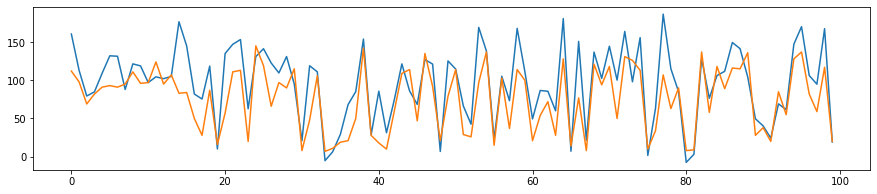

In [274]:
regr = linear_model.LinearRegression()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)


get_score(test_Y,prediction);

MSE: 1107.525085151343
R2 score: 0.35865158252172413
MAE: 26.099323592102


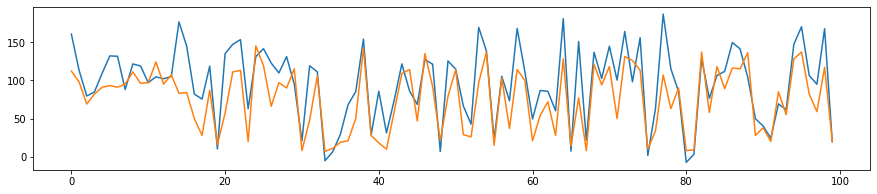

In [275]:
regr = linear_model.BayesianRidge()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

C:\Users\BERNARDO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MSE: 1057.4
R2 score: 0.3876781431556846
MAE: 24.06


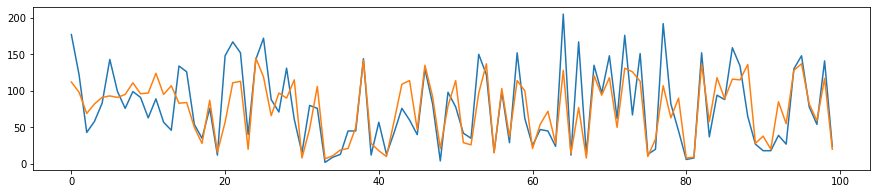

In [276]:
regr = linear_model.LogisticRegression()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 2769.375629645153
R2 score: -0.6036970189556603
MAE: 40.87930202123019


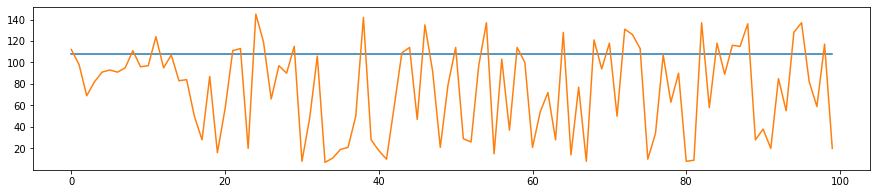

In [277]:
regr = linear_model.LassoLars()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 1108.9295414770158
R2 score: 0.35783828641316284
MAE: 26.118435810323646


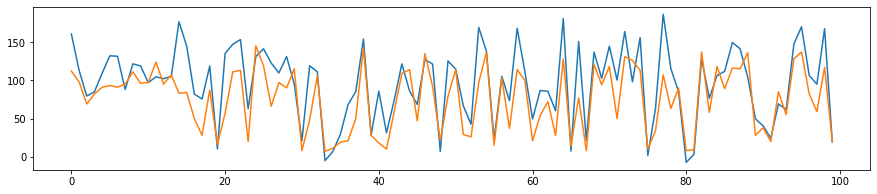

In [278]:
regr = linear_model.Ridge()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

MSE: 1173.9717620000004
R2 score: 0.32017347343424163
MAE: 25.607599999999998


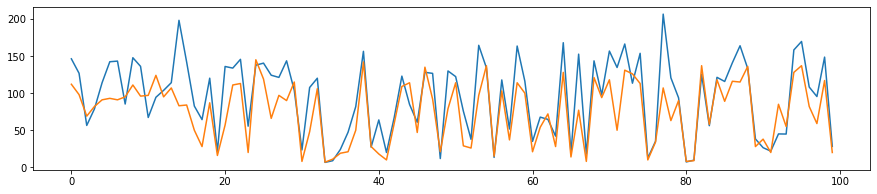

In [279]:
regr = RandomForestRegressor()
regr.fit(train_X, train_Y)
prediction = regr.predict(test_X)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

get_score(test_Y,prediction);

#### To do
- Retirar colunas de alta correlação
- Transformar colunas binarias em categóricas
- Ligar com outliers (skewness)